<a href="https://colab.research.google.com/github/ramya-njn/BERT-Text-Classification/blob/main/BERT_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Problem Statement:**

### Fine-tune BERT on Sentiment Classification task using "SetFit/Emotions" dataset from HuggingFace

### **Transfer Learning Approach:**

Load a pretrained BERT model and fine-tune a classifier head for downstream tasks like sentiment classification.

### **What is BERT?**

### BERT, Bidirectional Encoder Representation from Transformers, is a language model that is trained on a large corpus of unlabelled data. Unlike the earlier NLP approaches like word2Vec, BERT captures contexutal representations in a bidirectional manner. This implies that it takes into account the previous and the next word to encode a given word in a sentence generating contextually meaningful word embeddings.

### **BERT Architecture**

### BERT is a stack of Transformer encoder layers. Each encoder layer consists of multiple self-attention heads wrapped with a residual connection followed by layer normalization. The combined multi-head self attention output is fed to a feed-forward fully connected layer that is also with a residual connection followed by layer normalization. BERT models are pre-trained on two tasks: Masled Langugae Modelling (MLM) and Next Sentence Prediction (NSP). The pre-tranied model can be later fine-tuned on various tasks such as text classification, NER, question answering etc. For fine-tuning, one or more fully connected layers are added to the final encoder layer.



## **1. Import Libraries and Datasets**

In [1]:
!pip install transformers
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 35.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModel
from datasets import load_dataset, Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **2. Load Dataset**

In [4]:
dataset = load_dataset('SetFit/emotion')
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 2000
    })
})

In [5]:
# Convert Datasetdict into pandas format for visualization. Check train data

df_train = Dataset.to_pandas(dataset['train'])
df_train.head()

,text,label,label_text
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [6]:
label = df_train['label'].unique()
label_text = df_train['label_text'].unique()
print(label)
print(label_text)

[0 3 2 5 4 1]
['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


In [7]:
label_text_dict =  dict(zip(label, label_text))
label_text_dict = dict(sorted(label_text_dict.items()))
label_text_dict

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

## **3. Load pre-trained model and tokenizer**

In [8]:
model_version = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_version)
model = TFAutoModel.from_pretrained(model_version)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

## **4. Tokenize dataset in batches via Hugging Face batch mapping functionality**

In [9]:
def tokenize(batch):
  return tokenizer(batch['text'], padding = True, truncation = True, return_tensors = 'tf')

dataset_encoded = dataset.map(tokenize, batched = True, batch_size=None)
print(dataset_encoded)
print( dataset_encoded['train'][0]) ## first example from train data

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'label_text', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})
{'text': 'i didnt feel humiliated', 'label': 0, 'label_text': 'sadness', 'input_ids': [101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [10]:
# print individual features of the first two samples from the encoded train dataset.
print('text:', dataset_encoded['train'][:2]['text'])
print('label:', dataset_encoded['train'][:2]['label'])
print('input_ids:', dataset_encoded['train'][:2]['input_ids'])
print('token_type_ids:', dataset_encoded['train'][:2]['token_type_ids'])
print('attention_mask:', dataset_encoded['train'][:2]['attention_mask'])
print('Embedding size:',  len(dataset_encoded['train'][1]['input_ids']))

text: ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake']
label: [0, 0]
input_ids: [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
token_type_ids: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## **5. Convert Hugging Face dataset to tf.data.Dataset objects**

In [11]:
dataset_encoded.set_format('tf', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

In [12]:
# Define a function that groups all inputs to BERT as a single dictionary and outputs into (feature, label) pairs used for training Tensorflow models.
# Note that each feature is a dictionary of 'input_ids', 'token_type_ids' and  'attention_mask'

def feature_label(encoded_data):
  data = list(encoded_data.values())
  output = {'input_ids': data[1], 'token_type_ids': data[2], 'attention_mask': data[3]}, data[0]
  return output

In [13]:
# Create train, validation and test tf Datasets pipeline

batch_size = 64

train_dataset = tf.data.Dataset.from_tensor_slices(dataset_encoded['train'][:])
train_dataset = train_dataset.batch(64, drop_remainder=True).shuffle(1000)
train_dataset = train_dataset.map(feature_label, num_parallel_calls=tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices(dataset_encoded['validation'][:])
val_dataset = val_dataset.batch(64, drop_remainder=True).shuffle(100)
val_dataset = val_dataset.map(feature_label, num_parallel_calls=tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices(dataset_encoded['test'][:])
test_dataset = test_dataset.batch(64, drop_remainder=True).shuffle(100)
test_dataset = test_dataset.map(feature_label, num_parallel_calls=tf.data.AUTOTUNE)

In [14]:
print('Total # train_dataset batches:', len(train_dataset))
print('Total # val_dataset batches:', len(val_dataset))
print('Total # test_dataset batches:', len(test_dataset))

Total # train_dataset batches: 250
Total # val_dataset batches: 31
Total # test_dataset batches: 31


In [15]:
# Examine a batch from train_dataset

features, label = next(iter(train_dataset))
print('FEATURES:')
print(features)
print('LABELS:')
print(label)

FEATURES:
{'input_ids': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[  101, 10047,  3110, ...,     0,     0,     0],
       [  101, 10047,  3110, ...,     0,     0,     0],
       [  101,  1045,  2106, ...,     0,     0,     0],
       ...,
       [  101,  1045,  2228, ...,     0,     0,     0],
       [  101,  1045,  2572, ...,     0,     0,     0],
       [  101,  1045,  2074, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(64, 87), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}
LABELS:
tf.Tensor(
[3 4 0 1 0 2

## **6. BERT Classifier head using tensorflow keras model subclassing**

In [16]:
class BERTClassifierHead(tf.keras.Model):

  def __init__(self, bert_model, num_classes):
    super().__init__()
    self.bert = bert_model
    self.fc = tf.keras.layers.Dense(num_classes, activation='softmax')


  def call(self, inputs):
   x = self.bert(inputs)[1]
   out = self.fc(x)
   return out

## **7. Create model, compile and run**

In [17]:
bert_classifier = BERTClassifierHead(model, num_classes = 6)

In [18]:
bert_classifier.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5),
                        loss = tf.keras.losses.SparseCategoricalCrossentropy(),
                        metrics = ['accuracy'])

In [19]:
history = bert_classifier.fit(train_dataset, validation_data = val_dataset, epochs = 5)

Epoch 1/5
250/250 [==============================] - 361s 1s/step - loss: 0.5093 - accuracy: 0.8119 - val_loss: 0.1686 - val_accuracy: 0.9259
Epoch 2/5
250/250 [==============================] - 273s 1s/step - loss: 0.1324 - accuracy: 0.9413 - val_loss: 0.1524 - val_accuracy: 0.9355
Epoch 3/5
250/250 [==============================] - 274s 1s/step - loss: 0.0987 - accuracy: 0.9500 - val_loss: 0.1460 - val_accuracy: 0.9340
Epoch 4/5
250/250 [==============================] - 275s 1s/step - loss: 0.0851 - accuracy: 0.9574 - val_loss: 0.1410 - val_accuracy: 0.9410
Epoch 5/5
250/250 [==============================] - 274s 1s/step - loss: 0.0777 - accuracy: 0.9639 - val_loss: 0.1654 - val_accuracy: 0.9340


## **8. Plot loss and accuracy curves**

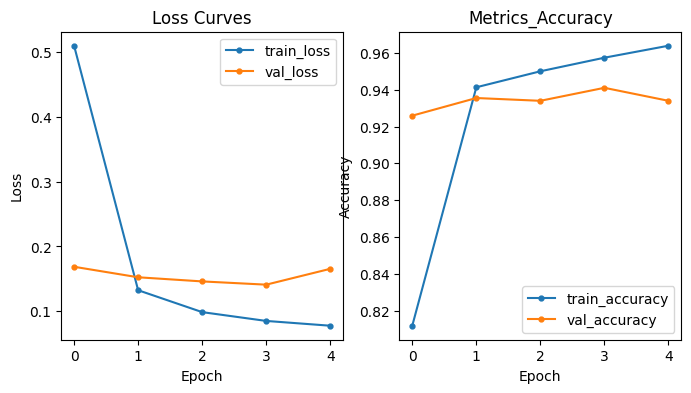

In [24]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

ax[0].plot(history.history['loss'], label='train_loss', marker='.', markersize=7)
ax[0].plot(history.history['val_loss'], label='val_loss', marker='.', markersize=7)
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Loss Curves')
ax[0].legend(loc='best')

ax[1].plot(history.history['accuracy'], label='train_accuracy', marker='.', markersize=7)
ax[1].plot(history.history['val_accuracy'], label='val_accuracy', marker='.', markersize=7)
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Metrics_Accuracy')
ax[1].legend(loc='best')

## **9. Model Evaluation**

In [25]:
loss, accuracy = bert_classifier.evaluate(test_dataset)

31/31 [==============================] - 19s 299ms/step - loss: 0.1816 - accuracy: 0.9284


## **10. Predictions**

In [26]:
# Group features and labels from test_dataset into separate lists

test_features = []
test_labels = []

for item in test_dataset:
  test_features.append(item[0])
  test_labels.append(item[1])

print(test_features[0], '\n')
print(test_labels[0])

{'input_ids': <tf.Tensor: shape=(64, 66), dtype=int64, numpy=
array([[  101,  1045,  2514, ...,     0,     0,     0],
       [  101, 10047,  2469, ...,     0,     0,     0],
       [  101,  1045,  2298, ...,     0,     0,     0],
       ...,
       [  101,  1045,  4209, ...,     0,     0,     0],
       [  101,  1045,  2787, ...,     0,     0,     0],
       [  101,  1045,  2428, ...,     0,     0,     0]])>, 'token_type_ids': <tf.Tensor: shape=(64, 66), dtype=int64, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(64, 66), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>} 

tf.Tensor(
[0 1 3 0 0 5 0 1 1 1 0 0 0 0

In [27]:
# Feed test_features into the model and get predictions

predictions = []

for inputs in test_features:
  out = bert_classifier.predict(inputs)
  out = np.argmax(out, axis=1)
  predictions.append(out)

print(predictions[:2])

2/2 [==============================] - 0s 133ms/step
[array([0, 1, 3, 0, 3, 5, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 4, 3, 4, 4, 0, 0,
       0, 1, 3, 1, 2, 3, 0, 0, 1, 3, 1, 1, 1, 0, 0, 4, 1, 1, 3, 2, 1, 3,
       2, 0, 0, 1, 1, 0, 5, 1, 2, 1, 0, 1, 1, 2, 1, 2, 1, 4, 1, 0]), array([1, 3, 0, 0, 4, 4, 1, 1, 1, 2, 2, 1, 1, 1, 2, 4, 4, 1, 3, 0, 1, 4,
       1, 0, 3, 0, 3, 3, 1, 4, 5, 1, 1, 1, 3, 1, 2, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 2, 4, 1, 0, 0, 0, 3, 1, 4, 0, 0, 0, 3, 2, 0])]


## **11. Model Performance**

### **Classification Report**

In [28]:
# Note: Convert predictions from list to tf.tensor format for comparison with test_labels

pred_labels = tf.convert_to_tensor(predictions)
print(pred_labels[:2])

true_labels = test_labels
print(true_labels[:2])

tf.Tensor(
[[0 1 3 0 3 5 0 1 1 1 0 0 0 0 0 1 4 3 4 4 0 0 0 1 3 1 2 3 0 0 1 3 1 1 1 0
  0 4 1 1 3 2 1 3 2 0 0 1 1 0 5 1 2 1 0 1 1 2 1 2 1 4 1 0]
 [1 3 0 0 4 4 1 1 1 2 2 1 1 1 2 4 4 1 3 0 1 4 1 0 3 0 3 3 1 4 5 1 1 1 3 1
  2 0 0 0 1 1 0 1 0 1 0 1 0 2 4 1 0 0 0 3 1 4 0 0 0 3 2 0]], shape=(2, 64), dtype=int32)
[<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([0, 1, 3, 0, 0, 5, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 4, 3, 4, 4, 0, 0,
       0, 1, 0, 1, 2, 3, 0, 0, 1, 3, 1, 1, 1, 0, 0, 4, 1, 1, 3, 2, 1, 3,
       2, 0, 0, 1, 1, 0, 1, 1, 2, 1, 0, 1, 1, 2, 1, 2, 1, 4, 1, 0])>, <tf.Tensor: shape=(64,), dtype=int64, numpy=
array([1, 3, 0, 0, 4, 4, 1, 1, 1, 2, 2, 1, 1, 1, 2, 4, 4, 1, 3, 0, 1, 4,
       1, 0, 3, 0, 3, 3, 1, 4, 5, 1, 1, 1, 3, 1, 2, 4, 0, 0, 1, 1, 4, 1,
       0, 1, 0, 1, 0, 2, 4, 1, 0, 0, 0, 3, 1, 5, 0, 0, 0, 3, 2, 0])>]


In [29]:
# Concatenate list of tensors

pred_labels = tf.concat([x for x in pred_labels], axis=0)
true_labels = tf.concat([x for x in true_labels], axis=0)

print(classification_report(true_labels, pred_labels))


              precision    recall  f1-score   support

           0       0.97      0.97      0.97       577
           1       0.98      0.91      0.95       692
           2       0.76      0.97      0.85       157
           3       0.88      0.95      0.91       270
           4       0.90      0.92      0.91       222
           5       0.93      0.59      0.72        66

    accuracy                           0.93      1984
   macro avg       0.90      0.89      0.88      1984
weighted avg       0.93      0.93      0.93      1984



### **Confusion Matrix**

In [30]:
cm = confusion_matrix(true_labels, pred_labels)
cm

array([[557,   2,   0,  15,   3,   0],
       [  2, 632,  49,   7,   0,   2],
       [  0,   4, 152,   1,   0,   0],
       [  8,   2,   0, 257,   3,   0],
       [  6,   0,   0,  10, 205,   1],
       [  2,   5,   0,   2,  18,  39]])

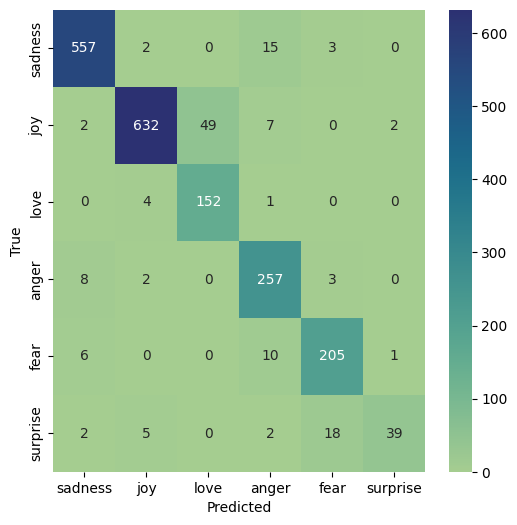

In [34]:
# labels = [0, 1, 2, 3, 4, 5] and emotions = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

df_cm = pd.DataFrame(cm, index = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], columns = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'])

plt.figure(figsize=(6,6))
sns.heatmap(df_cm, annot=True, cmap='crest', fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## **12. Save model**

In [36]:
bert_classifier.save_weights('/content/drive/MyDrive/bertfinetune')